In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 


from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for images, labels in test_loader:
    print(f'Batch size: {images.size(0)}') 
    break 


Batch size: 64


In [142]:
device = 'mps'

In [143]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [144]:
tf = transforms.Compose([transforms.ToTensor(),
 transforms.Normalize((0.1307,), (0.3081,))])

In [145]:
#3
train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=True, transform=tf),
batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(datasets.MNIST("./data/raw", download=True, train=False, transform=tf),
batch_size=64, shuffle=True)

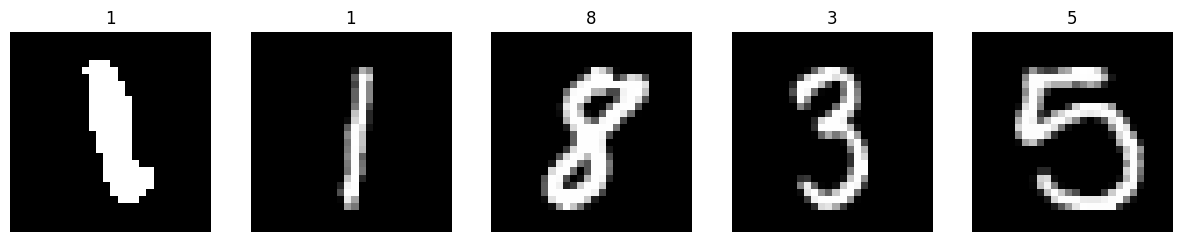

In [146]:

# Début du code
batch = next(iter(train_loader))
x = batch[0][:5]
y = batch[1][:5]

# Configuration pour les images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Boucle pour afficher chaque image
for i in range(5):
    image = x[i].numpy().squeeze()  
    label = y[i].item()

    axes[i].imshow(image, cmap='gray') 
    axes[i].set_title(f'{label}')
    axes[i].axis('off')

plt.show()


In [147]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super().__init__()
        
        # Définition de l'architecture du réseau
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernels * 4 * 4, out_features=50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.net(x)

n_kernels = 6
input_size = 28 * 28
output_size = 10 

model = ConvNet(input_size=input_size, n_kernels=n_kernels, output_size=output_size)
model.to(device)
print(model)


ConvNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=96, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [148]:
def train(model, train_loader, device, n_epoch=1, perm=torch.arange(0, 784).long()):
    # Code de la fonction train
    model.train()
    optimizer = torch.optim.AdamW(model.parameters())
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, (data, target) in enumerate(tqdm(train_loader)):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            optimizer.zero_grad()
            logits = model(data)
            loss = F.cross_entropy(logits, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch={epoch}, Step={i+1}: Loss={running_loss / 100:.4f}')
                running_loss = 0.0


In [149]:
def test(model, test_loader, device, perm=torch.arange(0, 784).long()):
    model.eval()  # Mettre le modèle en mode évaluation
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Désactiver la rétropropagation pour l'évaluation
        for data, target in tqdm(test_loader):  # Boucler sur le test loader avec une barre de progression
            data, target = data.to(device), target.to(device)  # Envoyer les données à l'appareil

            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)  # Aplatir les données
            data = data[:, perm]  # Appliquer la permutation
            data = data.view(-1, 1, 28, 28)  # Restructurer les données en format 1x28x28

            logits = model(data)  # Propagation avant pour obtenir les prédictions
            test_loss += F.cross_entropy(logits, target, reduction='sum').item()  # Calculer le loss total
            pred = logits.argmax(dim=1)  # Obtenir la prédiction avec la probabilité la plus élevée
            correct += pred.eq(target).sum().item()  # Compter les prédictions correctes
            total += target.size(0)  # Total des échantillons évalués

    test_loss /= total  # Calculer la perte moyenne
    accuracy = correct / total  # Calculer l'accuracy

    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
    return test_loss, accuracy  # Retourner les résultats de test


In [150]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernel, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernel, out_channels=n_kernel, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=n_kernel * 4 * 4, out_features=50),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.net(x)

In [151]:
train(model, train_loader, device, n_epoch=1)

 12%|█▏        | 111/938 [00:01<00:12, 68.65it/s]

Epoch=0, Step=100: Loss=1.0837


 22%|██▏       | 211/938 [00:03<00:11, 65.55it/s]

Epoch=0, Step=200: Loss=0.3458


 34%|███▎      | 315/938 [00:05<00:09, 67.71it/s]

Epoch=0, Step=300: Loss=0.2610


 43%|████▎     | 407/938 [00:06<00:07, 73.62it/s]

Epoch=0, Step=400: Loss=0.2419


 55%|█████▍    | 512/938 [00:07<00:05, 73.12it/s]

Epoch=0, Step=500: Loss=0.1881


 65%|██████▍   | 608/938 [00:09<00:04, 71.46it/s]

Epoch=0, Step=600: Loss=0.1727


 75%|███████▌  | 708/938 [00:10<00:03, 74.72it/s]

Epoch=0, Step=700: Loss=0.1529


 87%|████████▋ | 812/938 [00:12<00:01, 71.41it/s]

Epoch=0, Step=800: Loss=0.1399


 97%|█████████▋| 911/938 [00:13<00:00, 71.00it/s]

Epoch=0, Step=900: Loss=0.1354


100%|██████████| 938/938 [00:14<00:00, 66.75it/s]


In [154]:
test(model, train_loader, device)

100%|██████████| 938/938 [00:09<00:00, 97.56it/s] 

Test Loss: 0.1345, Accuracy: 0.9587


(0.13451152173876763, 0.9587166666666667)

In [157]:
n_kernels = 6
convnet = ConvNet(input_size, n_kernels, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")
train(convnet, train_loader, device, n_epoch=1)
test(convnet, train_loader, device)

Parameters=6.422K


 12%|█▏        | 110/938 [00:01<00:11, 69.95it/s]

Epoch=0, Step=100: Loss=1.2566


 23%|██▎       | 214/938 [00:03<00:10, 69.04it/s]

Epoch=0, Step=200: Loss=0.3411


 34%|███▎      | 315/938 [00:04<00:09, 68.23it/s]

Epoch=0, Step=300: Loss=0.2410


 44%|████▎     | 409/938 [00:05<00:07, 70.51it/s]

Epoch=0, Step=400: Loss=0.2089


 54%|█████▍    | 506/938 [00:07<00:05, 72.16it/s]

Epoch=0, Step=500: Loss=0.1677


 65%|██████▌   | 610/938 [00:08<00:04, 68.77it/s]

Epoch=0, Step=600: Loss=0.1450


 76%|███████▌  | 709/938 [00:10<00:03, 67.66it/s]

Epoch=0, Step=700: Loss=0.1413


 86%|████████▋ | 810/938 [00:11<00:01, 71.45it/s]

Epoch=0, Step=800: Loss=0.1179


 97%|█████████▋| 911/938 [00:13<00:00, 67.00it/s]

Epoch=0, Step=900: Loss=0.1288


100%|██████████| 938/938 [00:09<00:00, 96.88it/s] 

Test Loss: 0.1154, Accuracy: 0.9647


(0.11542057137389977, 0.9647333333333333)

In [158]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size) 
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.layers(x)

input_size = 28 * 28  
output_size = 10 
n_hidden = 8 

mlp = MLP(input_size, n_hidden, output_size)
mlp.to(device)

print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")

Parameters=6.442K


In [160]:
train(mlp, train_loader, device, n_epoch=1)

 12%|█▏        | 113/938 [00:01<00:08, 97.17it/s]

Epoch=0, Step=100: Loss=0.4683


 23%|██▎       | 212/938 [00:02<00:08, 87.68it/s]

Epoch=0, Step=200: Loss=0.4311


 34%|███▎      | 316/938 [00:03<00:06, 92.47it/s]

Epoch=0, Step=300: Loss=0.4409


 44%|████▍     | 416/938 [00:04<00:05, 96.12it/s]

Epoch=0, Step=400: Loss=0.4334


 55%|█████▌    | 516/938 [00:05<00:04, 95.52it/s]

Epoch=0, Step=500: Loss=0.4318


 66%|██████▌   | 616/938 [00:06<00:03, 91.47it/s]

Epoch=0, Step=600: Loss=0.4194


 76%|███████▋  | 716/938 [00:07<00:02, 91.54it/s]

Epoch=0, Step=700: Loss=0.4129


 86%|████████▌ | 809/938 [00:08<00:01, 96.51it/s]

Epoch=0, Step=800: Loss=0.4248


 97%|█████████▋| 909/938 [00:09<00:00, 88.72it/s]

Epoch=0, Step=900: Loss=0.4022


100%|██████████| 938/938 [00:10<00:00, 92.83it/s]


In [161]:
test(mlp, train_loader, device)

100%|██████████| 938/938 [00:08<00:00, 105.75it/s]

Test Loss: 0.3991, Accuracy: 0.8831


(0.3990856304725011, 0.8831333333333333)

In [162]:
cnn_parameters = sum(p.numel() for p in model.parameters())
mlp_parameters = sum(p.numel() for p in mlp.parameters())
print(f"Nombre de paramètres CNN: {cnn_parameters}")
print(f"Nombre de paramètres MLP: {mlp_parameters}")


Nombre de paramètres CNN: 6422
Nombre de paramètres MLP: 6442


In [166]:
import time

start_time = time.time()
train(model, train_loader, device, n_epoch=1)
cnn_training_time = time.time() - start_time

cnn_test_loss, cnn_test_accuracy = test(model, train_loader, device)


start_time = time.time()
train(mlp, train_loader, device, n_epoch=1)
mlp_training_time = time.time() - start_time

mlp_test_loss, mlp_test_accuracy = test(mlp, train_loader, device)

print(f"______________________")

print(f"CNN Temps d'entraînement : {cnn_training_time:.2f} secondes")
print(f"CNN Loss: {cnn_test_loss:.4f}")
print(f"CNN Accuracy: {cnn_test_accuracy:.4f}")

print(f"----------------------")

print(f"MLP Temps d'entraînement: {mlp_training_time:.2f} secondes")
print(f"MLP Loss: {mlp_test_loss:.4f}")
print(f"MLP Accuracy: {mlp_test_accuracy:.4f}")

print(f"______________________")

 12%|█▏        | 108/938 [00:01<00:11, 71.51it/s]

Epoch=0, Step=100: Loss=0.0731


 22%|██▏       | 208/938 [00:02<00:10, 72.40it/s]

Epoch=0, Step=200: Loss=0.0752


 33%|███▎      | 313/938 [00:04<00:08, 73.67it/s]

Epoch=0, Step=300: Loss=0.0900


 44%|████▎     | 409/938 [00:05<00:07, 73.20it/s]

Epoch=0, Step=400: Loss=0.0776


 55%|█████▍    | 513/938 [00:07<00:06, 68.01it/s]

Epoch=0, Step=500: Loss=0.0740


 65%|██████▌   | 611/938 [00:08<00:04, 69.88it/s]

Epoch=0, Step=600: Loss=0.0775


 75%|███████▌  | 707/938 [00:09<00:03, 72.95it/s]

Epoch=0, Step=700: Loss=0.0733


 86%|████████▋ | 811/938 [00:11<00:01, 71.67it/s]

Epoch=0, Step=800: Loss=0.0793


 97%|█████████▋| 908/938 [00:12<00:00, 72.64it/s]

Epoch=0, Step=900: Loss=0.0762


100%|██████████| 938/938 [00:09<00:00, 99.66it/s] 


Test Loss: 0.0717, Accuracy: 0.9770


 12%|█▏        | 112/938 [00:01<00:08, 98.17it/s]

Epoch=0, Step=100: Loss=0.3439


 23%|██▎       | 213/938 [00:02<00:07, 97.69it/s]

Epoch=0, Step=200: Loss=0.3619


 34%|███▎      | 315/938 [00:03<00:06, 96.12it/s] 

Epoch=0, Step=300: Loss=0.3313


 44%|████▍     | 416/938 [00:04<00:05, 97.01it/s]

Epoch=0, Step=400: Loss=0.3633


 55%|█████▌    | 517/938 [00:05<00:04, 97.60it/s]

Epoch=0, Step=500: Loss=0.3654


 66%|██████▌   | 619/938 [00:06<00:03, 97.92it/s]

Epoch=0, Step=600: Loss=0.3640


 76%|███████▌  | 711/938 [00:07<00:02, 99.65it/s]

Epoch=0, Step=700: Loss=0.3612


 87%|████████▋ | 815/938 [00:08<00:01, 95.16it/s] 

Epoch=0, Step=800: Loss=0.3649


 98%|█████████▊| 916/938 [00:09<00:00, 92.67it/s]

Epoch=0, Step=900: Loss=0.3476


100%|██████████| 938/938 [00:08<00:00, 109.67it/s]

Test Loss: 0.3501, Accuracy: 0.9016
CNN Temps d'entraînement : 13.15 secondes
CNN Loss: 0.0717
CNN Accuracy: 0.9770
----------------------
MLP Temps d'entraînement: 9.81 secondes
MLP Loss: 0.3501
MLP Accuracy: 0.9016


In [164]:
# Évaluer le CNN
cnn_test_loss, cnn_test_accuracy = test(model, train_loader, device)
print(f"Loss du CNN sur le jeu de test: {cnn_test_loss:.4f}")
print(f"Accuracy du CNN sur le jeu de test: {cnn_test_accuracy:.4f}")

# Évaluer le MLP
mlp_test_loss, mlp_test_accuracy = test(mlp, train_loader, device)
print(f"Loss du MLP sur le jeu de test: {mlp_test_loss:.4f}")
print(f"Accuracy du MLP sur le jeu de test: {mlp_test_accuracy:.4f}")


100%|██████████| 938/938 [00:10<00:00, 93.41it/s] 


Test Loss: 0.0919, Accuracy: 0.9718
Loss du CNN sur le jeu de test: 0.0919
Accuracy du CNN sur le jeu de test: 0.9718


100%|██████████| 938/938 [00:08<00:00, 109.73it/s]

Test Loss: 0.3700, Accuracy: 0.8948
Loss du MLP sur le jeu de test: 0.3700
Accuracy du MLP sur le jeu de test: 0.8948
